# Dataset download

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
########################################################
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.image import imread
########################################################
import torch
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch.nn.parallel import DataParallel
import torch.multiprocessing as mp
from PIL import Image
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
########################################################
import random
import os
from glob import glob
########################################################


In [2]:
!pip install torchsummary

In [3]:
from torchsummary import summary
# import tqdm

In [4]:
dogs_path = '/kaggle/input/stanford-dogs-dataset/images/Images'

# List subdirectories (breeds)
breeds = os.listdir(dogs_path)
print("Number of breeds:", len(breeds))
print("Example breeds:", breeds[:5])

# List files in one breed (adjust as needed)
breed_path = os.path.join(dogs_path, breeds[0])
images_in_breed = os.listdir(breed_path)
print("Number of images in one breed:", len(images_in_breed))
print("Example images:", images_in_breed[:5])


Number of breeds: 120
Example breeds: ['n02091635-otterhound', 'n02102318-cocker_spaniel', 'n02101388-Brittany_spaniel', 'n02088094-Afghan_hound', 'n02085936-Maltese_dog']
Number of images in one breed: 151
Example images: ['n02091635_965.jpg', 'n02091635_1329.jpg', 'n02091635_4698.jpg', 'n02091635_2120.jpg', 'n02091635_470.jpg']


In [5]:
animals_path = "/kaggle/input/animals10/raw-img"

animals = os.listdir(animals_path)
print("Number of animals:", len(animals))
print("Example animals:", animals[:5])
print(animals_path[:5])


Number of animals: 10
Example animals: ['cavallo', 'pecora', 'elefante', 'gatto', 'scoiattolo']
/kagg


## Dataloader config

In [6]:
class CombinedDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2

    def __len__(self):
        return len(self.dataset1) + len(self.dataset2)

    def __getitem__(self, idx):
        if idx < len(self.dataset1):
            return self.dataset1[idx]
        else:
            idx -= len(self.dataset1)
            return self.dataset2[idx]

In [7]:


# Basic transformations
basic_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Adjust the size as needed
    transforms.ToTensor(),
])

# Data augmentation transformations
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    # Add more augmentation techniques as needed
])


dataset = ImageFolder(root=dogs_path, transform=basic_transform)
dataset_2 = ImageFolder(root=animals_path, transform=basic_transform)
combined_dataset = CombinedDataset(dataset, dataset_2)

train_size = int(0.95 * len(combined_dataset))
test_size = len(combined_dataset) - train_size
train_dataset, test_dataset = random_split(combined_dataset, [train_size, test_size])
# Apply data augmentation to the training dataset
train_dataset.dataset.transform = transforms.Compose([
    basic_transform,
    data_augmentation
])

batch_size = 512  # set to 32 later

val_split = 0.2  # 20% of the training data for validation
num_val = int(val_split * len(train_dataset))
num_train = len(train_dataset) - num_val
train_data, val_data = random_split(train_dataset, [num_train, num_val])

# Create data loaders for train and validation sets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8,
                         shuffle=False, num_workers=4)  # look into collate fn

# Display batch
for images, targets in train_loader:
    print("Training Batch shape:", images.shape)
    break
for images, targets in val_loader:
    print("Val Batch shape:", images.shape)
    break

Training Batch shape: torch.Size([512, 3, 256, 256])
Val Batch shape: torch.Size([512, 3, 256, 256])


In [8]:
print(f"Total number of examples: {combined_dataset.__len__()}")

Total number of examples: 46759


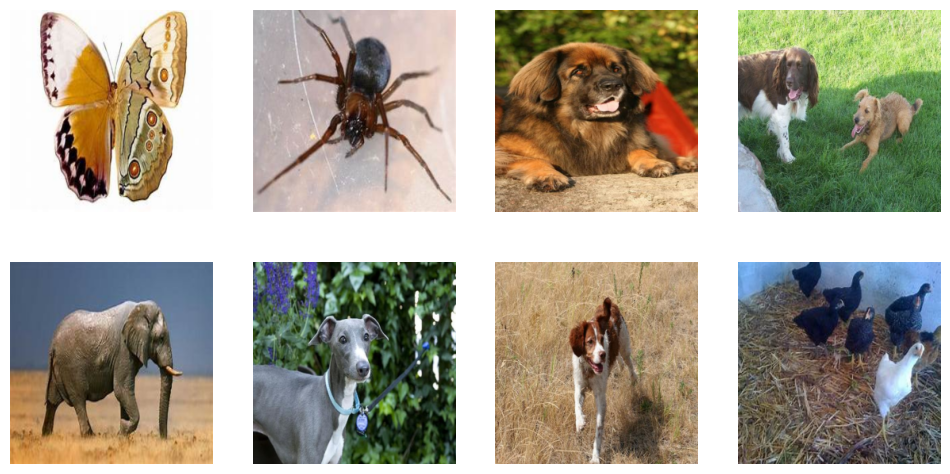

In [9]:
# Display batch with augmented images
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
axs = axs.flatten()

for i, (images, targets) in enumerate(train_loader):
    if i >= 8:
        break
    axs[i].imshow(transforms.ToPILImage()(images[0]))
    axs[i].axis('off')

plt.show()


# Building the network

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")

GPU: Tesla T4


## Conv architecture

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2)
        self.bottleneck = nn.Conv2d(512, 64, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.bottleneck(x)
        return x

# Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(64, 512, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.deconv5 = nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, padding=2, output_padding=1)

    def forward(self, x):
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = F.relu(self.deconv4(x))
        x = torch.sigmoid(self.deconv5(x))
        return x
# Progressive Image Compression
class ProgressiveAutoEncoder(nn.Module):
    def __init__(self):
        super(ProgressiveAutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        # Encode the input image
        encoded = self.encoder(x)

        # Progressive decoding
        decoded = self.decoder(encoded)
        residual = x - decoded
        return decoded, residual

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ProgressiveAutoEncoder()
model = model.to(device)
model = DataParallel(model) # enable for 2 gpu usage
print(model)

DataParallel(
  (module): ProgressiveAutoEncoder(
    (encoder): Encoder(
      (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (conv4): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (bottleneck): Conv2d(512, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (decoder): Decoder(
      (deconv1): ConvTranspose2d(64, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (deconv2): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
      (deconv3): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
      (deconv4): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
      (deconv5): ConvTranspose2d(64, 3

In [12]:
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           4,864
            Conv2d-2         [-1, 64, 128, 128]           4,864
            Conv2d-3          [-1, 128, 64, 64]         204,928
            Conv2d-4          [-1, 128, 64, 64]         204,928
            Conv2d-5          [-1, 256, 32, 32]         819,456
            Conv2d-6          [-1, 256, 32, 32]         819,456
            Conv2d-7          [-1, 512, 16, 16]       3,277,312
            Conv2d-8          [-1, 512, 16, 16]       3,277,312
            Conv2d-9           [-1, 64, 16, 16]         294,976
          Encoder-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]         294,976
          Encoder-12           [-1, 64, 16, 16]               0
  ConvTranspose2d-13          [-1, 512, 16, 16]         295,424
  ConvTranspose2d-14          [-1, 512,

## Model Training

In [13]:
checkpoint_dir = '/kaggle/working/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

#### Tune these params

In [14]:

################################# Training Hyperparameters ##############################

patience = 200  # Early stopping epochs
lr = 0.001
step_size = 80 # LR scheduling step size
gamma = 0.5 # LR scheduling decay factor
num_epochs = 200

#########################################################################################
early_stopping_counter = 0
min_val_loss = float('inf')
criterion = nn.MSELoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
#########################################################################################

train_losses = []
val_losses = []
best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
epoch_reached = num_epochs

# Set the path to the checkpoint file you want to resume from
checkpoint_path = '/kaggle/input/1209m-checkpoint/pytorch/120e9m/1/checkpoint_epoch_120.pth'

# Check if the checkpoint file exists
if os.path.isfile(checkpoint_path):
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path)

    # Initialize the model and optimizer
    model = ProgressiveAutoEncoder()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model = model.to(device)
    model = DataParallel(model) # enable for 2 gpu usage
    # Load the model and optimizer states from the checkpoint
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Retrieve other necessary variables from the checkpoint
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    min_val_loss = checkpoint.get('min_val_loss', float('inf'))
    early_stopping_counter = checkpoint.get('early_stopping_counter', 0)
    epoch_reached = checkpoint.get('epoch_reached', num_epochs)
    print(num_epochs)
    # Set the starting epoch for resuming training
    #num_epochs = num_epochs - (start_epoch - 1)
    print(num_epochs)
    print(f"Resuming training from epoch {start_epoch}")
else:
    print(f"Checkpoint file '{checkpoint_path}' not found. Starting from scratch.")
    start_epoch = 1
    min_val_loss = float('inf')
    early_stopping_counter = 0
    epoch_reached = num_epochs

################################# Training Loop #########################################

print(f"Starting training for {num_epochs} epochs. LR: {lr} Gamma: {gamma} Step: {step_size}")
print(f"{start_epoch} -> {num_epochs}")
for epoch in range(start_epoch, num_epochs + 1):
    running_loss = 0.0
#     train_pbar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")
    
    for data in train_loader:
        images, _ = data
        images = images.to(device)

        decoded, residual = model(images)  # Pass the input tensor directly
        reconstruction_loss = criterion(decoded, images)
        residual_loss = criterion(residual, torch.zeros_like(residual))
        loss = reconstruction_loss + residual_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # Compute validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
#         val_pbar = tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)")
        for val_data in val_loader:
            val_images, _ = val_data
            val_images = val_images.to(device)
            val_decoded, val_residual = model(val_images)  # Pass the input tensor directly
            val_reconstruction_loss = criterion(val_decoded, val_images)
            val_residual_loss = criterion(val_residual, torch.zeros_like(val_residual).to(device))
            val_loss += (val_reconstruction_loss + val_residual_loss).item()
            
    val_loss /= len(val_loader)
    model.train()

    # Early stopping
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            epoch_reached = epoch 
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Save checkpoint every 10 epochs
    checkpoint_interval = 10
    if (epoch + 1) % checkpoint_interval == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'min_val_loss': min_val_loss,
            'early_stopping_counter': early_stopping_counter,
            'epoch_reached': epoch_reached
        }, checkpoint_path)
        
    # Update the learning rate
    scheduler.step(val_loss)
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
    print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {epoch_loss:.6f}, Val Loss: {val_loss:.6f}')
    
#########################################################################################

200
200
Resuming training from epoch 120
Starting training for 200 epochs. LR: 0.001 Gamma: 0.5 Step: 80
120 -> 200
Epoch [120/200], Train Loss: 0.004891, Val Loss: 0.004900
Epoch [121/200], Train Loss: 0.004867, Val Loss: 0.004876
Epoch [122/200], Train Loss: 0.004845, Val Loss: 0.004852
Epoch [123/200], Train Loss: 0.004821, Val Loss: 0.004830
Epoch [124/200], Train Loss: 0.004800, Val Loss: 0.004808
Epoch [125/200], Train Loss: 0.004780, Val Loss: 0.004788
Epoch [126/200], Train Loss: 0.004762, Val Loss: 0.004768
Epoch [127/200], Train Loss: 0.004741, Val Loss: 0.004749
Epoch [128/200], Train Loss: 0.004722, Val Loss: 0.004731
Epoch [129/200], Train Loss: 0.004702, Val Loss: 0.004714
Epoch [130/200], Train Loss: 0.004684, Val Loss: 0.004697
Epoch [131/200], Train Loss: 0.004671, Val Loss: 0.004681
Epoch [132/200], Train Loss: 0.004655, Val Loss: 0.004665
Epoch [133/200], Train Loss: 0.004638, Val Loss: 0.004651
Epoch [134/200], Train Loss: 0.004627, Val Loss: 0.004637
Epoch [135/200

In [15]:

# train_losses = []
# val_losses = []
# best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
# epoch_reached = num_epochs

# ################################# Training Loop #########################################

# print(f"Starting training for {num_epochs} epochs. LR: {lr} Gamma: {gamma} Step: {step_size}")
# for epoch in range(num_epochs):
    
#     running_loss = 0.0
#     train_pbar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")
    
#     for data in train_loader:
#         images, _ = data
#         images = images.to(device)

#         decoded, residual = model(images)
#         reconstruction_loss = criterion(decoded, images)
#         residual_loss = criterion(residual, torch.zeros_like(residual))
#         loss = reconstruction_loss + residual_loss

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#         train_pbar.set_postfix(loss=loss.item())
#         # Compute validation loss
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         val_pbar = tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)")
#         for val_data in val_loader:
#             val_images, _ = val_data
#             val_images = val_images.to(device)
#             val_decoded, val_residual = model(val_images)
#             val_reconstruction_loss = criterion(val_decoded, val_images)
#             val_residual_loss = criterion(val_residual, torch.zeros_like(val_residual).to(device))
#             val_loss += (val_reconstruction_loss + val_residual_loss).item()
            
#     val_loss /= len(val_loader)
#     model.train()

#     # Early stopping
#     if val_loss < min_val_loss:
#         min_val_loss = val_loss
#         early_stopping_counter = 0
#         torch.save(model.state_dict(), best_model_path)
#     else:
#         early_stopping_counter += 1
#         if early_stopping_counter >= patience:
#             epoch_reached = epoch 
#             print(f'Early stopping at epoch {epoch+1}')
#             break

#     # Save checkpoint every 10 epochs
#     checkpoint_interval = 10
#     if (epoch + 1) % checkpoint_interval == 0:
#         checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
#         torch.save({
#             'epoch': epoch + 1,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'train_loss': epoch_loss,
#             'val_loss': val_loss
#         }, checkpoint_path)

#     # Update the learning rate
#     scheduler.step()
    
#     epoch_loss = running_loss / len(train_loader)
#     train_losses.append(epoch_loss)
#     val_losses.append(val_loss)
#     print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.6f}, Val Loss: {val_loss:.6f}')
    
# #########################################################################################


In [16]:
torch.save(model.module.encoder.state_dict(), 'PgIC_encoder_9M.pth')
torch.save(model.module.decoder.state_dict(), 'PgIC_decoder_9M.pth')

### Saving the encoder and decoder weights separately

# Using the encoder-decoder

## Load the models (switch to GPU later)

In [17]:
encoder = Encoder()
encoder.load_state_dict(torch.load('PgIC_encoder_9M.pth'))
encoder.eval()

decoder = Decoder()
decoder.load_state_dict(torch.load('PgIC_decoder_9M.pth'))
decoder.eval()

Decoder(
  (deconv1): ConvTranspose2d(64, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (deconv3): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (deconv4): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (deconv5): ConvTranspose2d(64, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
)

In [18]:
from torchvision.utils import make_grid

In [19]:
import time
timings = []

## Plotting the images, reconstructions and latent spaces

0.871312141418457
compressed_size: torch.Size([8, 64, 16, 16])


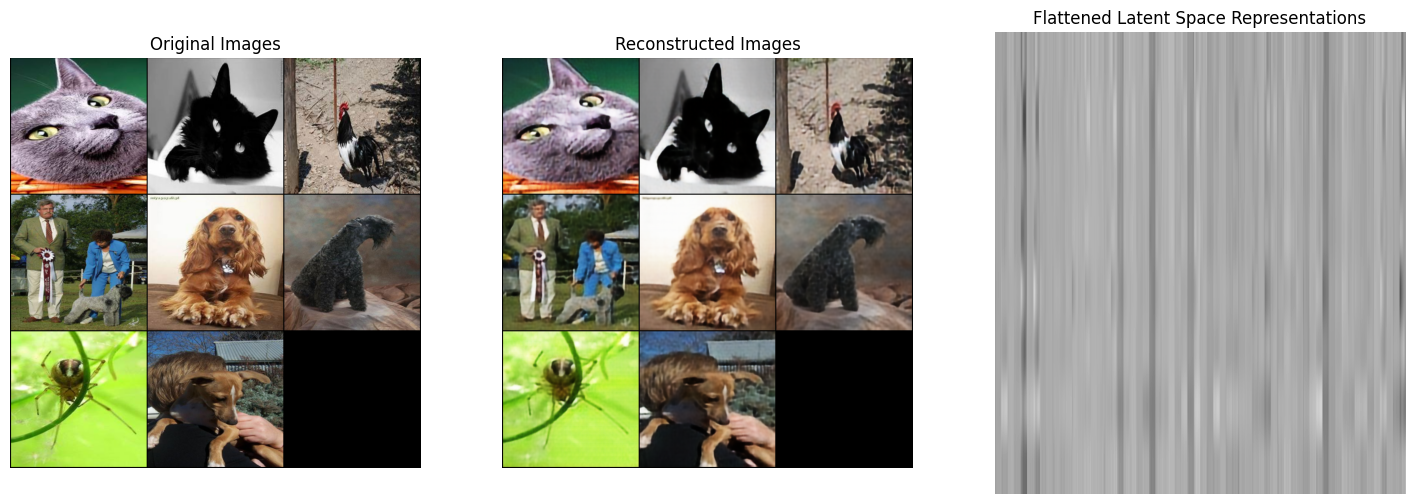

In [20]:
test_images, _ = next(iter(test_loader))

start_time = time.time()
compressed_representations = encoder(test_images)
reconstructed_images = decoder(compressed_representations)
end_time = time.time()
print(end_time - start_time)
print("compressed_size:", compressed_representations.shape)
# Flatten the latent space representations
flattened_latent = compressed_representations.detach().view(compressed_representations.size(0), -1)

# Create a grid of original, reconstructed, and latent space images
original_grid = make_grid(test_images, nrow=3, normalize=True)
reconstructed_grid = make_grid(reconstructed_images, nrow=3, normalize=True)

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(np.transpose(original_grid.numpy(), (1, 2, 0)))
ax[0].set_title('Original Images')
ax[0].axis('off')

ax[1].imshow(np.transpose(reconstructed_grid.numpy(), (1, 2, 0)))
ax[1].set_title('Reconstructed Images')
ax[1].axis('off')

ax[2].imshow(flattened_latent.numpy(), cmap='gray', aspect='auto')
ax[2].set_title('Flattened Latent Space Representations')
ax[2].axis('off')

plt.show()

In [21]:
from skimage.metrics import structural_similarity as ssim

## Plotting the SSIMs of images over a batch of 16 samples from the test loader

(256, 256, 3)
(256, 256, 3)
0.72137284
(256, 256, 3)
(256, 256, 3)
0.9510017
(256, 256, 3)
(256, 256, 3)
0.6828024
(256, 256, 3)
(256, 256, 3)
0.7143062
(256, 256, 3)
(256, 256, 3)
0.8732893
(256, 256, 3)
(256, 256, 3)
0.85083777
(256, 256, 3)
(256, 256, 3)
0.8849804
(256, 256, 3)
(256, 256, 3)
0.77685505


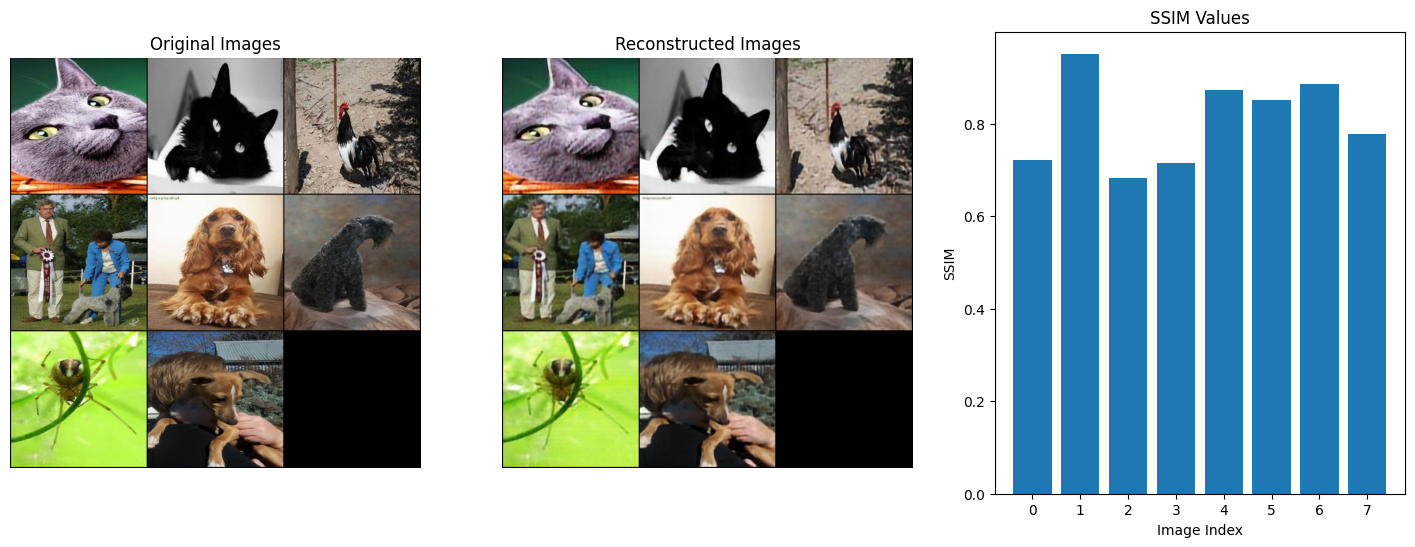

In [22]:
ssim_values = []
for orig_img, recon_img in zip(test_images, reconstructed_images):
    orig_img_np = orig_img.permute(1, 2, 0).detach().cpu().numpy()
    recon_img_np = recon_img.permute(1, 2, 0).detach().cpu().numpy()
    print(orig_img_np.shape)
    print(recon_img_np.shape)
    ssim_val = ssim(orig_img_np, recon_img_np, data_range=1.0, multichannel=True, channel_axis=2)
    print(ssim_val)
    ssim_values.append(ssim_val)

# Create a grid of original and reconstructed images
original_grid = make_grid(test_images, nrow=3, normalize=True)
reconstructed_grid = make_grid(reconstructed_images, nrow=3, normalize=True)

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(np.transpose(original_grid.numpy(), (1, 2, 0)))
ax[0].set_title('Original Images')
ax[0].axis('off')

ax[1].imshow(np.transpose(reconstructed_grid.numpy(), (1, 2, 0)))
ax[1].set_title('Reconstructed Images')
ax[1].axis('off')

ax[2].bar(range(len(ssim_values)), ssim_values)
ax[2].set_title('SSIM Values')
ax[2].set_xlabel('Image Index')
ax[2].set_ylabel('SSIM')

plt.show()

In [23]:
s = 0
for i in ssim_values:
    s += i
print(s/len(ssim_values))

0.80693069845438


ValueError: x and y must have same first dimension, but have shapes (120,) and (199,)

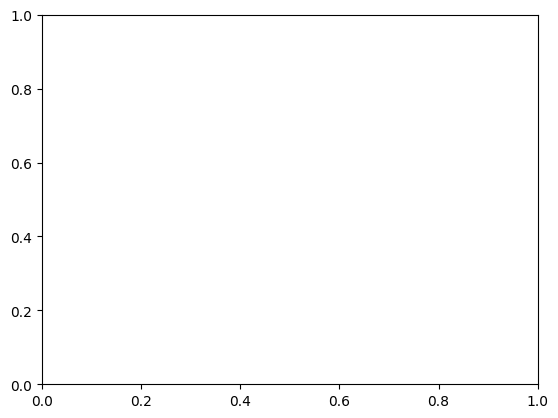

In [24]:
plt.figure()
plt.plot(range(epoch_reached), train_losses, label='Training Loss')
plt.plot(range(epoch_reached), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Report